## **1. Parte Descarga y Preparación Datos**

### **1.1 Descarga y pre-procesado datos**

In [ ]:
import pandas as pd
import numpy as np

full_df = pd.read_csv('/content/drive/MyDrive/airbnb-listings-extract.csv', delimiter=';', decimal='.')

#full_df.info()

In [ ]:
#df_pictures = df_pictures.dropna()
full_df = full_df.dropna(subset=['Picture Url']) #Thumbnail
full_df = full_df.dropna(subset=['Price'])

#full_df.info()

In [ ]:
# Nos quedamos para esta versión de la práctica con la forma de descarga de imágenes propuesta, ya que es más eficiente que la que estaba planteando anteriormente

from tqdm import tqdm
import cv2
import imageio.v3 as io
from typing import Optional

def download_images(paths: list,
                    canvas: tuple = (224, 224),
                    nb_channels: int = 3,
                    max_imgs: Optional[int] = None
                    ) -> tuple:
  """ Download a list of images from url adresses, converting them to a specific
  canvas size.

  Args:
    paths: Paths or url adresses from which to load images.
    canvas: Desired image width and height.
    nb_channels: Channels in images (1 for B/W, 3 for RGB).
    max_imgs: Upper threshold in the number of images to download.

  Return:
    a tuple of:
      - image values
      - indices within the paths that were successfull.

  """
  n_images = len(paths) if not max_imgs else max_imgs
  images = np.zeros((n_images, canvas[0], canvas[1], nb_channels),
                       dtype=np.uint8)
  downloaded_idxs = []

  for i_img, url in enumerate(tqdm(paths, total=n_images)):
    if i_img >= n_images:
      break
    try:
        img = io.imread(url)
        img = cv2.resize(img, (canvas[0], canvas[1]))
        downloaded_idxs.append(i_img)
        images[i_img] = img
    except (IOError, ValueError) as e:  # Unavailable url / conversion error
        pass
  return images[downloaded_idxs], downloaded_idxs

In [ ]:
images, idxs = download_images(full_df['Picture Url'], max_imgs=3000) # O Thumbnail
images = images.astype("float32") / 255.
images.shape

In [ ]:
df_filtered = full_df.iloc[idxs]
print(df_filtered.head())

In [ ]:
# Vamos a crear un dataframe filtrado, donde nos quedaremos con las columnas que pueden ser de utilidad para el modelo tabular. A partir del dataset filtrado,
# trataremos valores NA y veremos qué necesitamos

df_filtered = df_filtered[['Amenities', 'Host Total Listings Count', 'Latitude', 'Longitude', 'Property Type', 'Room Type',
                       'Cancellation Policy', 'Accommodates', 'Bathrooms', 'Bedrooms', 'Beds','Guests Included', 'Price', 'Extra People',
                       'Minimum Nights', 'Maximum Nights', 'Number of Reviews']]

df_filtered.info()

In [ ]:
# Guardamos los datos para poder usarlos después
import numpy as np

np.save('/content/drive/MyDrive/Images_ABB_Tris/images.npy', images)
df_filtered.to_csv('/content/drive/MyDrive/Images_ABB_Tris/filtered_data.csv', sep=';', index=False)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **1.2 Carga, división y análisis**

In [ ]:
import pandas as pd
import numpy as np

saved_data = pd.read_csv("/content/drive/MyDrive/Images_ABB_Bis/filtered_data.csv", sep=';')
saved_imgs = np.load("/content/drive/MyDrive/Images_ABB_Bis/images.npy")
saved_data.shape, saved_imgs.shape

((3000, 17), (3000, 224, 224, 3))

In [ ]:
# Vamos a dividir los datos para el modelo tabular

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

X = saved_data.drop('Price', axis=1)
y = saved_data['Price']

# Creamos las categorias de precios para el clasificador y codificamos:
price_categories = ['Economic', 'Standard', 'Luxury']

y_categories = pd.qcut(y, q=len(price_categories), labels=price_categories)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_categories)
y_one_hot = to_categorical(y_encoded, num_classes=len(price_categories))


# Hacemos la división de los datos para el modelo tabular
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=1)


# Verificar los tamaños de los conjuntos
print("Tamaño de train:", X_train.shape)
print("Tamaño de val:", X_val.shape)
print("Tamaño de test:", X_test.shape)

Tamaño de train: (2040, 16)
Tamaño de val: (360, 16)
Tamaño de test: (600, 16)


In [ ]:
# En Amenities, existen variables que pueden ser relevantes. Nos quedaremos con TV, Wireless Internet, Air conditioning, Kitchen,
# Wheelchair accessible, Breakfast. Crearemos una variable binaria para cada una:

from sklearn.preprocessing import LabelEncoder

X_train['TV'] = X_train['Amenities'].str.contains('TV')
X_train['TV'] = X_train['TV'].fillna(False).astype(int)

X_train['Wireless Internet'] = X_train['Amenities'].str.contains('Wireless Internet')
X_train['Wireless Internet'] = X_train['Wireless Internet'].fillna(False).astype(int)

X_train['Air conditioning'] = X_train['Amenities'].str.contains('Air conditioning')
X_train['Air conditioning'] = X_train['Air conditioning'].fillna(False).astype(int)

X_train['Kitchen'] = X_train['Amenities'].str.contains('Kitchen')
X_train['Kitchen'] = X_train['Kitchen'].fillna(False).astype(int)

X_train['Wheelchair accessible'] = X_train['Amenities'].str.contains('Wheelchair accessible')
X_train['Wheelchair accessible'] = X_train['Wheelchair accessible'].fillna(False).astype(int)

X_train['Breakfast'] = X_train['Amenities'].str.contains('Breakfast')
X_train['Breakfast'] = X_train['Breakfast'].fillna(False).astype(int)

# Elimino Amenities tras sacar la información interesante
X_train.drop(['Amenities'], axis = 1, inplace = True)

# Utilizamos LabelEncoder para codificar las variables no numéricas que nos interesan:
le_Property = LabelEncoder()
le_Room = LabelEncoder()
le_Cancellation = LabelEncoder()

X_train['Property Type'] = le_Property.fit_transform(X_train['Property Type'])
X_train['Room Type'] = le_Room.fit_transform(X_train['Room Type'])
X_train['Cancellation Policy'] = le_Cancellation.fit_transform(X_train['Cancellation Policy'])

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2040 entries, 2932 to 719
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Host Total Listings Count  2040 non-null   float64
 1   Latitude                   2040 non-null   float64
 2   Longitude                  2040 non-null   float64
 3   Property Type              2040 non-null   int64  
 4   Room Type                  2040 non-null   int64  
 5   Cancellation Policy        2040 non-null   int64  
 6   Accommodates               2040 non-null   int64  
 7   Bathrooms                  2033 non-null   float64
 8   Bedrooms                   2036 non-null   float64
 9   Beds                       2036 non-null   float64
 10  Guests Included            2040 non-null   int64  
 11  Extra People               2040 non-null   int64  
 12  Minimum Nights             2040 non-null   int64  
 13  Maximum Nights             2040 non-null   int

In [ ]:
# Existe una pequeña cantidad de valores nulos en algunas columnas ('Host Total Listings Count', 'Bathrooms', 'Bedrooms', 'Beds')
# Imputaremos la mediana de los datos de train a estos valores, ya que es menos sensible a los valores extremos que la media

columnas = ['Host Total Listings Count', 'Bathrooms', 'Bedrooms', 'Beds']
medians = {}
for columna in columnas:
    medians[columna] = np.nanmedian(X_train[columna])
print(medians)
for columna in columnas:
    mediana = medians[columna]
    X_train[columna].fillna(mediana, inplace=True)


X_train.info()

{'Host Total Listings Count': 2.0, 'Bathrooms': 1.0, 'Bedrooms': 1.0, 'Beds': 1.0}
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2040 entries, 2932 to 719
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Host Total Listings Count  2040 non-null   float64
 1   Latitude                   2040 non-null   float64
 2   Longitude                  2040 non-null   float64
 3   Property Type              2040 non-null   int64  
 4   Room Type                  2040 non-null   int64  
 5   Cancellation Policy        2040 non-null   int64  
 6   Accommodates               2040 non-null   int64  
 7   Bathrooms                  2040 non-null   float64
 8   Bedrooms                   2040 non-null   float64
 9   Beds                       2040 non-null   float64
 10  Guests Included            2040 non-null   int64  
 11  Extra People               2040 non-null   int64  
 12  Minimum Nights     

In [ ]:
# Ahora vamos a aplicar a validation y test la misma normalización y transformación que hemos aplicado a train con los valores de test:
X_test['TV'] = X_test['Amenities'].str.contains('TV')
X_test['TV'] = X_test['TV'].fillna(False).astype(int)

X_test['Wireless Internet'] = X_test['Amenities'].str.contains('Wireless Internet')
X_test['Wireless Internet'] = X_test['Wireless Internet'].fillna(False).astype(int)

X_test['Air conditioning'] = X_test['Amenities'].str.contains('Air conditioning')
X_test['Air conditioning'] = X_test['Air conditioning'].fillna(False).astype(int)

X_test['Kitchen'] = X_test['Amenities'].str.contains('Kitchen')
X_test['Kitchen'] = X_test['Kitchen'].fillna(False).astype(int)

X_test['Wheelchair accessible'] = X_test['Amenities'].str.contains('Wheelchair accessible')
X_test['Wheelchair accessible'] = X_test['Wheelchair accessible'].fillna(False).astype(int)

X_test['Breakfast'] = X_test['Amenities'].str.contains('Breakfast')
X_test['Breakfast'] = X_test['Breakfast'].fillna(False).astype(int)

# Elimino Amenities tras sacar la información interesante
X_test.drop(['Amenities'], axis = 1, inplace = True)

# Utilizamos LabelEncoder para codificar las variables no numéricas que nos interesan:
le_Property = LabelEncoder()
le_Room = LabelEncoder()
le_Cancellation = LabelEncoder()

X_test['Property Type'] = le_Property.fit_transform(X_test['Property Type'])
X_test['Room Type'] = le_Room.fit_transform(X_test['Room Type'])
X_test['Cancellation Policy'] = le_Cancellation.fit_transform(X_test['Cancellation Policy'])

for columna in columnas:
    mediana = medians[columna] # medians es un diccionario que contiene los valores de la mediana de train de cada una de las variables a las que hay que imputar NAs
    X_test[columna].fillna(mediana, inplace=True)


################################# Lo mismo para Validation ##########################

X_val['TV'] = X_val['Amenities'].str.contains('TV')
X_val['TV'] = X_val['TV'].fillna(False).astype(int)

X_val['Wireless Internet'] = X_val['Amenities'].str.contains('Wireless Internet')
X_val['Wireless Internet'] = X_val['Wireless Internet'].fillna(False).astype(int)

X_val['Air conditioning'] = X_val['Amenities'].str.contains('Air conditioning')
X_val['Air conditioning'] = X_val['Air conditioning'].fillna(False).astype(int)

X_val['Kitchen'] = X_val['Amenities'].str.contains('Kitchen')
X_val['Kitchen'] = X_val['Kitchen'].fillna(False).astype(int)

X_val['Wheelchair accessible'] = X_val['Amenities'].str.contains('Wheelchair accessible')
X_val['Wheelchair accessible'] = X_val['Wheelchair accessible'].fillna(False).astype(int)

X_val['Breakfast'] = X_val['Amenities'].str.contains('Breakfast')
X_val['Breakfast'] = X_val['Breakfast'].fillna(False).astype(int)

# Elimino Amenities tras sacar la información interesante
X_val.drop(['Amenities'], axis = 1, inplace = True)

# Utilizamos LabelEncoder para codificar las variables no numéricas que nos interesan:
le_Property = LabelEncoder()
le_Room = LabelEncoder()
le_Cancellation = LabelEncoder()

X_val['Property Type'] = le_Property.fit_transform(X_val['Property Type'])
X_val['Room Type'] = le_Room.fit_transform(X_val['Room Type'])
X_val['Cancellation Policy'] = le_Cancellation.fit_transform(X_val['Cancellation Policy'])

for columna in columnas:
    mediana = medians[columna]
    X_val[columna].fillna(mediana, inplace=True)

In [ ]:
# Ahora trabajaremos con las imágenes

# Hacemos la división de los datos
images_train, images_test = train_test_split(saved_imgs, test_size=0.2, random_state=1)
images_train, images_val = train_test_split(images_train, test_size=0.15, random_state=1)

# Verificar los tamaños de los conjuntos
print("Tamaño de train imag:", images_train.shape)
print("Tamaño de train:", X_train.shape)
print("Tamaño de val imag:", images_val.shape)
print("Tamaño de val:", X_val.shape)
print("Tamaño de test imag:", images_test.shape)
print("Tamaño de test:", X_test.shape)

Tamaño de train imag: (2040, 224, 224, 3)
Tamaño de train: (2040, 21)
Tamaño de val imag: (360, 224, 224, 3)
Tamaño de val: (360, 21)
Tamaño de test imag: (600, 224, 224, 3)
Tamaño de test: (600, 21)


Vamos a entrenar ahora un modelo para los datos tabulares. Comenzaremos con una red neuronal y después probaremos también con Arboles de decisión, para comparar los resultados

## **2. Entrenamiento Datos tabulares**

### **2.1 Red neuronal densa**

Entrenamiento del modelo...
Epoch 1/20
16/16 [==============================] - 37s 22ms/step - loss: 1.4727 - accuracy: 0.3399 - val_loss: 1.1271 - val_accuracy: 0.3528
Epoch 2/20
16/16 [==============================] - 0s 5ms/step - loss: 1.3548 - accuracy: 0.3492 - val_loss: 1.0944 - val_accuracy: 0.3806
Epoch 3/20
16/16 [==============================] - 0s 6ms/step - loss: 1.3372 - accuracy: 0.3526 - val_loss: 1.0875 - val_accuracy: 0.4111
Epoch 4/20
16/16 [==============================] - 0s 5ms/step - loss: 1.3484 - accuracy: 0.3399 - val_loss: 1.1029 - val_accuracy: 0.3667
Epoch 5/20
16/16 [==============================] - 0s 5ms/step - loss: 1.2855 - accuracy: 0.3443 - val_loss: 1.1097 - val_accuracy: 0.3722
Epoch 6/20
16/16 [==============================] - 0s 5ms/step - loss: 1.3077 - accuracy: 0.3335 - val_loss: 1.1075 - val_accuracy: 0.3528
Epoch 7/20
16/16 [==============================] - 0s 7ms/step - loss: 1.2261 - accuracy: 0.3786 - val_loss: 1.1112 - val_accurac

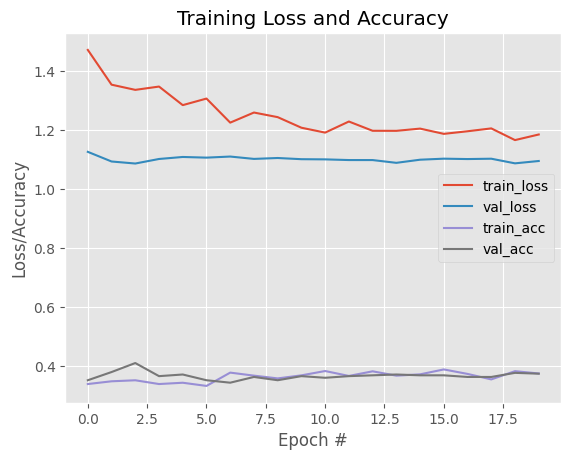

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


# Hiper-parámetros
lr = 0.005
epochs = 20
batch_size = 128

# Implementamos el modelo.
# Para comenzar a trabajar, implementaremos una arquitectura con una capa Dense de entrada, que recibirá los 21 parámetros del input, y activación ReLU.
# Otra capa oculta de 64 neuronas con activación ReLU y una capa Densa de salida con 3 neuronas y activación Softmax para clasificación.
# Además, aplicamos regularización con Dropout (probamos desactivando un 20%)
model = Sequential()
model.add(Dense(128, input_shape=(21,), activation="relu")) # Tenemos 21 variables de entrada
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(3, activation="softmax"))

# Compilamos e implementamos el modelo
print("Entrenamiento del modelo...")
model.compile(loss="categorical_crossentropy", optimizer=SGD(lr), metrics=["accuracy"])
H = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)

# Evaluamos el modelo con test
print("Evaluación del modelo...")
predictions = model.predict(X_test, batch_size=batch_size)
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1)))

# Gráfica de accuracy y losses
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

El rendimiento general no es bueno, sin embargo, probaremos a hacer ahora algunos ajustes en los hiper-parámetros, así como aumentar las épocas y probar diferentes batch-sizes.


Entrenamiento del modelo...
Epoch 1/200
128/128 [==============================] - 4s 13ms/step - loss: 1.3207 - accuracy: 0.3610 - val_loss: 1.0976 - val_accuracy: 0.3139
Epoch 2/200
128/128 [==============================] - 1s 7ms/step - loss: 1.1832 - accuracy: 0.3791 - val_loss: 1.0962 - val_accuracy: 0.3528
Epoch 3/200
128/128 [==============================] - 1s 5ms/step - loss: 1.1484 - accuracy: 0.3806 - val_loss: 1.0998 - val_accuracy: 0.3361
Epoch 4/200
128/128 [==============================] - 1s 5ms/step - loss: 1.1377 - accuracy: 0.3850 - val_loss: 1.1052 - val_accuracy: 0.3222
Epoch 5/200
128/128 [==============================] - 1s 4ms/step - loss: 1.1106 - accuracy: 0.3870 - val_loss: 1.1308 - val_accuracy: 0.3111
Epoch 6/200
128/128 [==============================] - 1s 4ms/step - loss: 1.1220 - accuracy: 0.3855 - val_loss: 1.1092 - val_accuracy: 0.3444
Epoch 7/200
128/128 [==============================] - 1s 5ms/step - loss: 1.0821 - accuracy: 0.3977 - val_loss: 

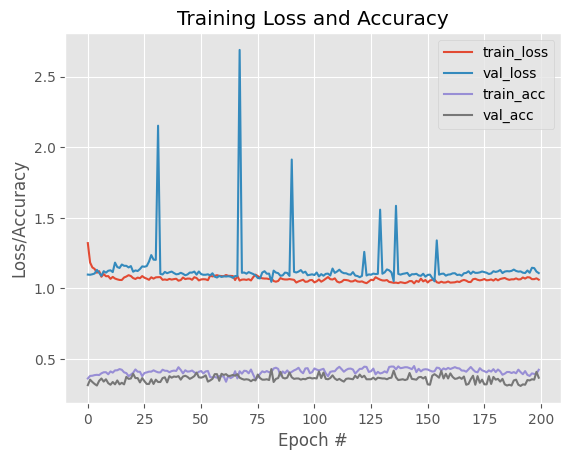

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


# Hiper-parámetros
lr = 0.01
epochs = 200
batch_size = 16

# Implementamos el modelo.
model = Sequential()
model.add(Dense(128, input_shape=(x_train.shape[1],), activation="relu"))
model.add(BatchNormalization()) # Probamos con BatchNormalization además de Dropout
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(3, activation="softmax"))

# Compilamos e implementamos el modelo
print("Entrenamiento del modelo...")
model.compile(loss="categorical_crossentropy", optimizer=SGD(lr), metrics=["accuracy"])
H = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)

# Evaluamos el modelo con test
print("Evaluación del modelo...")
predictions = model.predict(X_test, batch_size=batch_size)
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1)))

# Gráfica de accuracy y losses
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

Los resultados mejoran, pero no son buenos. Podríamos aumentar el número de capas o probar con diferentes arquitecturas, además de darle más tiempo de entrenamiento. Por ahora probaremos con otros modelos.

### **2.2 Modelos ML**

Hemos visto que manteniendo la arquitectura pero probando con diferentes valores en los hiperparámetros estamos obteniendo resultados algo mejores, sin embargo, el resultado en sí es bastante deficiente. Igual son sorprendentes los picos que aparecen en la gráfica de pérdidas en validación. Quizás pueda deberse a la escasez de datos. Habrá que averiguar al respecto.


Vamos a probar ahora con algunos modelos de ML basados en árboles de decisión como **XGBoost** y RandomForest:

In [ ]:
# Boosted Trees

# Ahora trabajaremos con XGBoost

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

Niterations = [100, 200, 500]
learningRate = [0.1, 0.05, 0.01]
maxDepth = [5, 7, 10]
param_grid = {'n_estimators': Niterations, 'learning_rate': learningRate, 'max_depth' : maxDepth}

grid = GridSearchCV(XGBClassifier(random_state = 0), param_grid = param_grid)
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))




best mean cross-validation score: 0.694
best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}


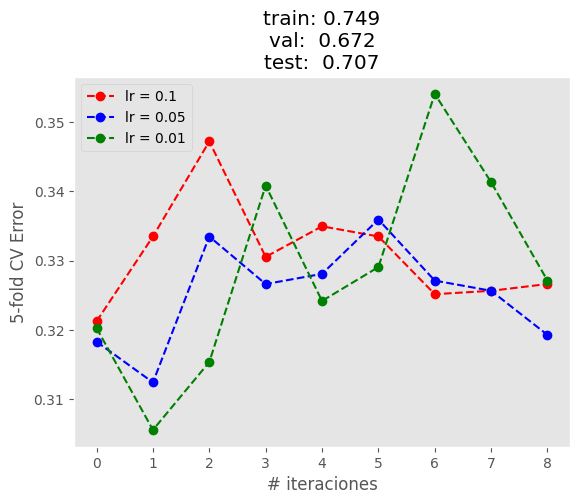

In [ ]:
lrOptimo = grid.best_params_['learning_rate']
neOptimo = grid.best_params_['n_estimators']
maxDepthOptimo = grid.best_params_['max_depth']


xgb = XGBClassifier(random_state = 0, max_depth = maxDepthOptimo, learning_rate = lrOptimo, n_estimators = neOptimo) #,
                   #reg_alpha = 0.6, reg_lambda = 0.6)
xgb.fit(X_train, y_train)

error = 1-grid.cv_results_['mean_test_score'].reshape(len(learningRate), -1)
colors = ['r','b','g','k','m']

for i, lr in enumerate(learningRate):
  x = np.arange(len(error[i, :]))
  plt.plot(x, error[i,:], colors[i] + '--o', label = 'lr = %g'%lr)

plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('5-fold CV Error')
plt.title('train: %0.3f\nval:  %0.3f\ntest:  %0.3f'%(xgb.score(X_train,y_train), xgb.score(X_val, y_val), xgb.score(X_test,y_test)))
plt.grid()
plt.show()

In [ ]:
# Veamos con Random Forest

import numpy as np
from sklearn.ensemble import RandomForestClassifier

maxDepth = range(1, 15)
#nEstimators = [100, 200, 300, 500, 1000]
#maxDepth = 9
nEstimators = 200
param_grid = {'max_depth': maxDepth}#, 'n_estimators': nEstimators}

grid = GridSearchCV(RandomForestClassifier(random_state=0, max_features='sqrt', n_estimators=200), scoring='accuracy', param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))


best mean cross-validation score: 0.701
best parameters: {'max_depth': 14}


In [ ]:
scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')

plt.show()

NameError: ignored

Estamos obteniendo unos resultados notablemente superiores en el modelo ML, por lo que en esta versión nos quedaremos o bien con un modelo Random Forest o bien con XGBoost, que están dando resultados similares.

## **3. Entrenamiento modelos con Imágenes**

Ahora vamos a trabajar con las **imágenes**.
Vamos a utilizar algunas de las **arquitecturas preentrenadas** que se utilizan de forma habitual.
Trataremos en primer lugar de obtener un **baseline** para cada uno de estos modelos. Haremos **transfer learning** adaptando la capa de clasificación a nuestras necesidades.
Tras ello, probaremos a reentrenar algún bloque convolucional (**fine tunning**) partiendo desde la última capa hacia atrás, para ir viendo si la tendencia mejora o empeora los resultados y poder decidir qué modelo usaremos en la fusión.



### **3.1 Parte Arquitectura CNN VGG16**

Comenzaremos trabajando con uno de los modelos que se llevan utilizando desde hace más tiempo, **VGG16**, para ver el desempeño general con nuestras imágenes e ir viendo hacia dónde se puede ir posteriormente con otros modelos.

In [ ]:
# Trabajaremos primero con VGG16

from tensorflow.keras import callbacks
from tensorflow.keras import optimizers, Model
from tensorflow.keras. layers import Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16

# Primero deberíamos adaptar el tamaño de nuestras imágenes (originalmente las redimensionamos a 224x224, que es exactamente el tipo de tamaño que espera VGG16, asíque NO hay hacerlo):
input_shape = (224, 224, 3)


# Modelo base
base_model = VGG16(weights='imagenet', include_top=False, input_shape = input_shape)
#base_model.summary()

58889256/58889256 [==============================] - 0s 0us/step


Vamos a reentrenar la capa de clasificación, a partir de aquí, veremos hacia dónde van los resultados y también probaremos a reentrenar alguna capa convolucional

In [ ]:
# Entrenaremos y evaluaremos el modelo para obtener un baseline sobre el que iterar después
# Reentrenaremos la capa de clasificación (Transfer learning)

# Modelo base
base_model = VGG16(weights='imagenet', include_top=False, input_shape = input_shape)
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Congelamos las capas convolucionales del base_model para que no se entrenen de nuevo y reentrenar solo el top-model (transfer-learning)
for layer in base_model.layers:
  layer.trainable = False
  print('Capa' + layer.name + ' congelada.')

last = base_model.layers[-1].output

x = Flatten()(last)
x = Dense(64, activation='relu')(x)
x = Dense(3, activation='softmax', name='predictions')(x)

modelImageVGG16 = Model(base_model.input, x)

modelImageVGG16.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

modelImageVGG16.summary()

Capainput_2 congelada.
Capablock1_conv1 congelada.
Capablock1_conv2 congelada.
Capablock1_pool congelada.
Capablock2_conv1 congelada.
Capablock2_conv2 congelada.
Capablock2_pool congelada.
Capablock3_conv1 congelada.
Capablock3_conv2 congelada.
Capablock3_conv3 congelada.
Capablock3_pool congelada.
Capablock4_conv1 congelada.
Capablock4_conv2 congelada.
Capablock4_conv3 congelada.
Capablock4_pool congelada.
Capablock5_conv1 congelada.
Capablock5_conv2 congelada.
Capablock5_conv3 congelada.
Capablock5_pool congelada.
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     

Ahora que ya tenemos la arquitectura definida para el base-model, comenzamos con el entrenamiento

In [ ]:
epochs = 2 # Definimos solo dos épocas por cuestión de tiempos de ejecución (evidentemente puede ser muy mejorable el resultado)
batch_size = 64

H = modelImageVGG16.fit(images_train, y_train, batch_size=batch_size, validation_data=(images_val, y_val), epochs=epochs)

Epoch 1/2
32/32 [==============================] - 1762s 55s/step - loss: 1.6143 - accuracy: 0.3721 - val_loss: 1.1356 - val_accuracy: 0.3778
Epoch 2/2
32/32 [==============================] - 1707s 54s/step - loss: 0.9691 - accuracy: 0.4814 - val_loss: 1.0645 - val_accuracy: 0.4333


Evaluación del modelo...
10/10 [==============================] - 432s 43s/step
              precision    recall  f1-score   support

           0       0.47      0.73      0.57       188
           1       0.53      0.15      0.23       188
           2       0.40      0.46      0.43       224

    accuracy                           0.45       600
   macro avg       0.47      0.44      0.41       600
weighted avg       0.46      0.45      0.41       600



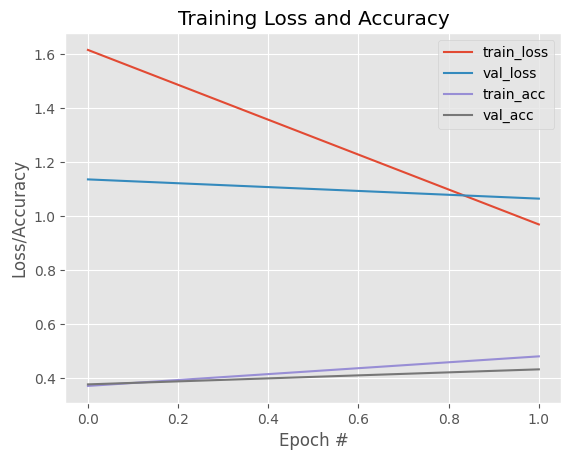

In [ ]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Evaluamos el modelo con test
print("Evaluación del modelo...")
predictions = modelImageVGG16.predict(images_test, batch_size=batch_size)
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1)))

# Gráfica de accuracy y losses
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

En la gráfica se ve que con más épocas podríamos mejorar sustancialmente los resultados, pero por razones de tiempo (este modelo es particularmente lento) vamos a reentrenar la última capa convolucional y veremos si puede haber mejora. Después también probaremos a reentrenar la penúltima capa.

In [ ]:
 # Vamos a hacer fine-tunning, ya que modificaremos también algunas capas de la parte convolucional

from keras.layers import Conv2D, MaxPooling2D
from keras.constraints import max_norm

for layer in base_model.layers:
  layer.trainable = False
  print('Capa' + layer.name + ' congelada.')
  if layer.name == 'block5_conv3':
    layer.trainable = True

last = base_model.layers[-2].output

# Última capa convolucional
x = Conv2D(1000, kernel_size=(3, 3), activation='relu')(last)

# Agregaremos max pooling en esta capa convolucional
x = MaxPooling2D(pool_size=(2, 2))(x)

# Clasificador
x = Flatten()(x)
# Vamos a ver en el clasificador a establecer restricciones para que ninguna neurona se vaya en el peso
x = Dense(64, activation='relu', kernel_constraint=max_norm(3.))(x)
# También aplicaremos regularización por Dropout, con 20% de neuronas desactivadas.
x = Dropout(0.2)(x)
x = Dense(3, activation='softmax', name='predictions')(x)

modelImageVGG16 = Model(base_model.input, x)

modelImageVGG16.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

modelImageVGG16.summary()

Capainput_2 congelada.
Capablock1_conv1 congelada.
Capablock1_conv2 congelada.
Capablock1_pool congelada.
Capablock2_conv1 congelada.
Capablock2_conv2 congelada.
Capablock2_pool congelada.
Capablock3_conv1 congelada.
Capablock3_conv2 congelada.
Capablock3_conv3 congelada.
Capablock3_pool congelada.
Capablock4_conv1 congelada.
Capablock4_conv2 congelada.
Capablock4_conv3 congelada.
Capablock4_pool congelada.
Capablock5_conv1 congelada.
Capablock5_conv2 congelada.
Capablock5_conv3 congelada.
Capablock5_pool congelada.
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     

Epoch 1/2
32/32 [==============================] - 2142s 67s/step - loss: 1.5755 - accuracy: 0.3358 - val_loss: 1.0900 - val_accuracy: 0.3722
Epoch 2/2
32/32 [==============================] - 2095s 66s/step - loss: 1.0807 - accuracy: 0.4162 - val_loss: 1.0982 - val_accuracy: 0.3528
Evaluación del modelo...
10/10 [==============================] - 519s 52s/step
              precision    recall  f1-score   support

           0       0.73      0.09      0.15       188
           1       0.32      0.99      0.49       188
           2       0.00      0.00      0.00       224

    accuracy                           0.34       600
   macro avg       0.35      0.36      0.21       600
weighted avg       0.33      0.34      0.20       600



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


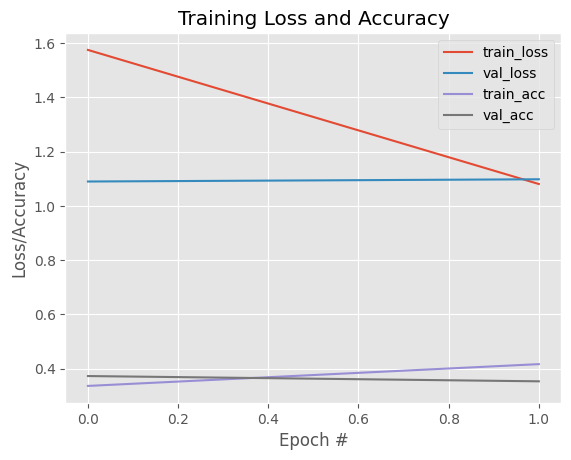

In [ ]:
# Entrenamos y evaluamos
epochs = 2
batch_size = 64

H = modelImageVGG16.fit(images_train, y_train, batch_size=batch_size, validation_data=(images_val, y_val), epochs=epochs)

# Evaluamos el modelo con test
print("Evaluación del modelo...")
predictions = modelImageVGG16.predict(images_test, batch_size=batch_size)
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1)))

# Gráfica de accuracy y losses
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

Sería bueno también probar con más capas hacia atrás, pero dado que el entrenamiento de este modelo es muy lento, vamos a probar con otros más eficientes en cuanto a tiempo. (Dejaremos en todo caso los bloques de código creados para futuras pruebas).

En cualquier caso, entrenando una sola capa hacia atrás no logramos mejorar los resultados respecto del modelo base. Sería importante en caso de usar esta arquitectura ir reentrenando más capas convolucionales y añadiendo otras capas, regularización, etc.

In [ ]:
# Veamos los resultados reentrenando también la penúltima capa convolucional

for layer in base_model.layers:
  layer.trainable = False
  print('Capa' + layer.name + ' congelada.')
  if layer.name == 'block5_conv3' or layer.name == 'block5_conv2':
    layer.trainable = True

last = base_model.layers[-3].output

x = Conv2D(1000, kernel_size=(3, 3) activation='relu')(last)
x = Dropout(0.2)(x)
x = Conv2D(1000, kernel_size=(3, 3) activation='relu')(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(3, activation='softmax', name='predictions')(x)

modelImageVGG16 = Model(base_model.input, x)

modelImageVGG16.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

modelImageVGG16.summary()

In [ ]:
# Entrenamos y evaluamos
epochs = 20
batch_size = 64

H = modelImageVGG16.fit(images_train, y_train, batch_size=batch_size, validation_data=(images_val, y_val), epochs=epochs)


# Evaluamos el modelo con test
print("Evaluación del modelo...")
predictions = modelImageVGG16.predict(images_test, batch_size=batch_size)
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1)))

# Gráfica de accuracy y losses
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

Vemos que el modelo VGG16 tiene tiempos de entrenamiento muy elevados. Vamos a probar ahora con modelos más rápidos como ResNet.

También vamos a probar después con una arquitectura que se está usando mucho para imágenes con buenos resultados: ViT (Vision Transformer). Necesitaremos de la arquitectura Transformer, en la que aún no tenemos práctica, así que intentaremos hacerla funcionar y ver qué resultados nos da.

In [ ]:
# Vamos a optimizar los hiper-parámetros para tratar de mejorar los resultados.
# Para ello vamos a probar con Autokeras, que básicamente automatiza el proceso de selección y ajuste. Lo utilizaremos para encontrar los mejores hiperparámetros

#! pip install --upgrade autokeras

import autokeras as ak

clf = ak.ImageClassifier(max_trials = 10)
clf.fit(images_train, y_train, epochs = 5)

print("Best hyperparameters: ", clf.export_model().hyperparameters)
print("Accuracy validation: ", clf.evaluate(images_val, y_val))
print("Accuracy test: ", clf.evaluate(images_test, y_test))

Trial 2 Complete [02h 22m 37s]
val_loss: 1.11051607131958

Best val_loss So Far: 1.0662652254104614
Total elapsed time: 03h 03m 42s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
efficient         |vanilla           |image_block_1/block_type
True              |True              |image_block_1/normalize
True              |False             |image_block_1/augment
True              |None              |image_block_1/image_augmentation_1/horizontal_flip
False             |None              |image_block_1/image_augmentation_1/vertical_flip
0                 |None              |image_block_1/image_augmentation_1/contrast_factor
0                 |None              |image_block_1/image_augmentation_1/rotation_factor
0.1               |None              |image_block_1/image_augmentation_1/translation_factor
0                 |None              |image_block_1/image_augmentation_1/zoom_factor
True              |None              |image_block_1/efficient_net_block_

Notar que sería bueno tratar de obtener unos **hiper-parámetros óptimos **(**Autokeras** podría hasta indicarnos la arquitectura óptima). Pero dejaremos esta parte indicada para probarla más adelante (y como muestra de la intención :) ), ya que por problemas con Colab y los largos tiempos de ejecución, hacen dificil poder completarla (como se puede ver, cada Trial exigía unas tres horas :( )

### **3.2 Parte Arquitectura CNN ResNet**

Ahora probaremos con la arquitectura **ResNet50**, que es una de las de uso más habitual en la actualidad.

In [ ]:
# Implementaremos nuestro modelo con ResNet50

from keras.applications import ResNet50
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D


input_shape = (224, 224, 3)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape = input_shape)

base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

Es muy notable la diferencia de tamaño entre las arquitecturas VGG y la ResNet.

In [ ]:
from keras.layers import Flatten
from keras.optimizers import Adam

for layer in base_model.layers:
  layer.trainable = False
  print('Capa' + layer.name + ' congelada')

last = base_model.layers[-1].output

# Agregamos la capa de clasificación
x = Flatten()(last)
x = Dense(64, activation='relu')(x)
x=Dense(3, activation='softmax', name='predictions')(x)

# Instanciamos y compilamos el modelo
modelResNet = Model(base_model.input, x)
modelResNet.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

modelResNet.summary()

Capainput_2 congelada
Capaconv1_pad congelada
Capaconv1_conv congelada
Capaconv1_bn congelada
Capaconv1_relu congelada
Capapool1_pad congelada
Capapool1_pool congelada
Capaconv2_block1_1_conv congelada
Capaconv2_block1_1_bn congelada
Capaconv2_block1_1_relu congelada
Capaconv2_block1_2_conv congelada
Capaconv2_block1_2_bn congelada
Capaconv2_block1_2_relu congelada
Capaconv2_block1_0_conv congelada
Capaconv2_block1_3_conv congelada
Capaconv2_block1_0_bn congelada
Capaconv2_block1_3_bn congelada
Capaconv2_block1_add congelada
Capaconv2_block1_out congelada
Capaconv2_block2_1_conv congelada
Capaconv2_block2_1_bn congelada
Capaconv2_block2_1_relu congelada
Capaconv2_block2_2_conv congelada
Capaconv2_block2_2_bn congelada
Capaconv2_block2_2_relu congelada
Capaconv2_block2_3_conv congelada
Capaconv2_block2_3_bn congelada
Capaconv2_block2_add congelada
Capaconv2_block2_out congelada
Capaconv2_block3_1_conv congelada
Capaconv2_block3_1_bn congelada
Capaconv2_block3_1_relu congelada
Capaconv2_

Epoch 1/2
32/32 [==============================] - 549s 17s/step - loss: 4.1974 - accuracy: 0.3456 - val_loss: 1.3374 - val_accuracy: 0.3917
Epoch 2/2
32/32 [==============================] - 533s 17s/step - loss: 1.2715 - accuracy: 0.4343 - val_loss: 1.5395 - val_accuracy: 0.3500
Evaluación del modelo...
10/10 [==============================] - 134s 13s/step
              precision    recall  f1-score   support

           0       0.54      0.24      0.33       188
           1       0.00      0.00      0.00       188
           2       0.39      0.90      0.54       224

    accuracy                           0.41       600
   macro avg       0.31      0.38      0.29       600
weighted avg       0.31      0.41      0.31       600



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


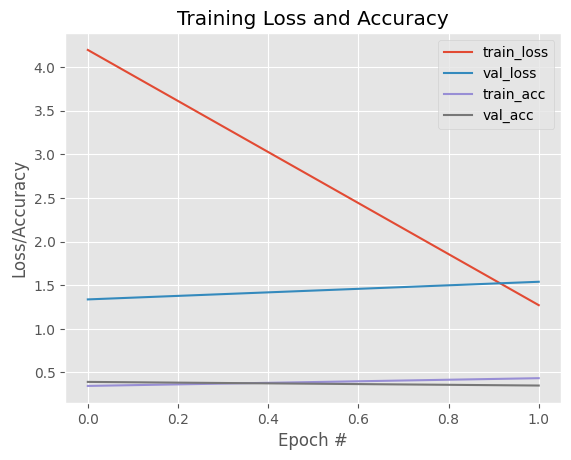

In [ ]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


epochs = 2  # Vamos a darle solo dos épocas para no eternizarnos esperando ya que además colab falla bastante si se queda solo...
batch_size = 64

H = modelResNet.fit(images_train, y_train, batch_size=batch_size, validation_data=(images_val, y_val), epochs=epochs)

# Evaluamos el modelo con test
print("Evaluación del modelo...")
predictions = modelResNet.predict(images_test, batch_size=batch_size)
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1)))

# Gráfica de accuracy y losses
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

Evidentemente se ve que con más épocas mejorarían los resultados, pero ya se puede apreciar que este modelo mejora de partida los resultados respecto al VGG16

In [ ]:
# Vamos a reentrenar también la última capa convolucional (y según los resultados y cómo vayamos de tiempo, algunas más)
# También vamos a incluir una capa de GlobalPooling tras la última convolucional, para reducir la dimensión de los mapas que lleguen al clasificador

In [ ]:
from keras.layers import Conv2D

for layer in base_model.layers:
  layer.trainable = False
  print('Capa' + layer.name + ' congelada')
  if layer.name == '':
    layer.trainable = True

last = base_model.layers[-2].output

# Modificamos la última convolucional

x = Conv2D(1000, kernel_size=(3, 3), activation='relu')(last)
x = GlobalAveragePooling2D()(x)
# Agregamos la capa de clasificación
x = Flatten()(last)
x = Dense(64, activation='relu')(x)
x = Dense(3, activation='softmax', name='predictions')(x)

# Instanciamos y compilamos el modelo
modelResNet = Model(base_model.input, x)
modelResNet.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

#modelResNet.summary()

Capainput_2 congelada
Capaconv1_pad congelada
Capaconv1_conv congelada
Capaconv1_bn congelada
Capaconv1_relu congelada
Capapool1_pad congelada
Capapool1_pool congelada
Capaconv2_block1_1_conv congelada
Capaconv2_block1_1_bn congelada
Capaconv2_block1_1_relu congelada
Capaconv2_block1_2_conv congelada
Capaconv2_block1_2_bn congelada
Capaconv2_block1_2_relu congelada
Capaconv2_block1_0_conv congelada
Capaconv2_block1_3_conv congelada
Capaconv2_block1_0_bn congelada
Capaconv2_block1_3_bn congelada
Capaconv2_block1_add congelada
Capaconv2_block1_out congelada
Capaconv2_block2_1_conv congelada
Capaconv2_block2_1_bn congelada
Capaconv2_block2_1_relu congelada
Capaconv2_block2_2_conv congelada
Capaconv2_block2_2_bn congelada
Capaconv2_block2_2_relu congelada
Capaconv2_block2_3_conv congelada
Capaconv2_block2_3_bn congelada
Capaconv2_block2_add congelada
Capaconv2_block2_out congelada
Capaconv2_block3_1_conv congelada
Capaconv2_block3_1_bn congelada
Capaconv2_block3_1_relu congelada
Capaconv2_

In [ ]:
epochs = 2
batch_size = 64

H = modelResNet.fit(images_train, y_train, batch_size=batch_size, validation_data=(images_val, y_val), epochs=epochs)


Epoch 1/2
32/32 [==============================] - 613s 19s/step - loss: 83.3885 - accuracy: 0.3338 - val_loss: 1.0988 - val_accuracy: 0.3111
Epoch 2/2
32/32 [==============================] - 547s 17s/step - loss: 1.0987 - accuracy: 0.3279 - val_loss: 1.0988 - val_accuracy: 0.3111


Evaluación del modelo...
10/10 [==============================] - 154s 15s/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       188
           1       0.00      0.00      0.00       188
           2       0.37      1.00      0.54       224

    accuracy                           0.37       600
   macro avg       0.12      0.33      0.18       600
weighted avg       0.14      0.37      0.20       600



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


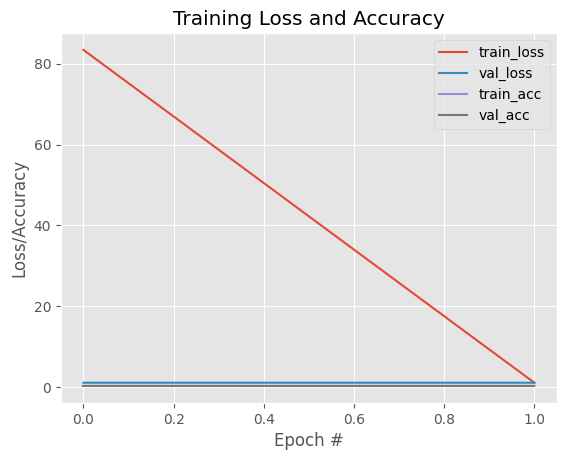

In [ ]:
# Evaluamos el modelo con test
print("Evaluación del modelo...")
predictions = modelResNet.predict(images_test, batch_size=batch_size)
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1)))

# Gráfica de accuracy y losses
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

Sucede lo mismo que VGG, con solo entrenar una capa convolucional, el modelo no obtiene unos resultados mejores. Sería importante entrenar más capas si usamos este modelo.

Pero queremos encontrar modelos más ligeros y rápidos, ya que no tenemos el tiempo ni la capacidad deprocesamiento aquí para poder hacer un mejor trabajo con esos modelos.

Vamos a probar con un modelo muy ligero, como EfficientNetB0, a ver si con unos tiempos mucho más bajos podemos hacer un entrenamiento más largo y obtener mejores resultados.

### **3.3 Parte Arquitectura CNN EfficientNetB0**

Vamos a probar con esta arquitectura CNN que forma parte de la familia **EfficientNet**, desarrollada en 2019, que tiene como características principales la eficiencia y un rendimiento superior en tareas de clasificación de imágenes, por lo que en la **búsqueda de eficiencia** dentro de las CNN puede ser una buena alternativa para nosotros.

Utiliza una técnica llamada **escalado compuesto** que ajusta de forma automática la anchura y profundidad de la red, en lugar de tener una arquitectura específica. La B0, es la más liviana de la familia.

In [ ]:
# Vamos a probar con una arquitectura que se centra en la eficiencia: EfficientNetB0

from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
import cv2
import numpy as np

input_shape = (224, 224, 3)
epochs = 3
batch_size = 32

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Congelamos las capas
for layer in base_model.layers:
  layer.trainable = False

# Agregar la capa de reducción de dimensionalidad
x = GlobalAveragePooling2D()(base_model.output)
# Agregamos la capa de clasificación
x = Dense(256, activation='relu')(x)
x = Dense(3, activation='softmax')(x)

# Invocamos el modelo
model = Model(base_model.input, x)

# Compilamos
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['Accuracy'])

# Entrenamos
model.fit(images_train, y_train, batch_size=batch_size, validation_data=(images_val, y_val), epochs=epochs)

loss, accuracy = model.evaluate(images_test, y_test)
print("Test Loss: ", loss)
print("Test Accuracy: ", accuracy)

16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/3
64/64 [==============================] - 144s 2s/step - loss: 1.1388 - Accuracy: 0.3397 - val_loss: 1.1040 - val_Accuracy: 0.3361
Epoch 2/3
64/64 [==============================] - 121s 2s/step - loss: 1.1053 - Accuracy: 0.3490 - val_loss: 1.1007 - val_Accuracy: 0.3361
Epoch 3/3
19/19 [==============================] - 28s 1s/step - loss: 1.0964 - Accuracy: 0.3733
Test Loss:  1.0963767766952515
Test Accuracy:  0.3733333349227905


In [ ]:
# Vamos a reentrenar la última capa convolucional
from keras.layers import Conv2D, Flatten

for layer in base_model.layers:
  layer.trainable = False
  print('Capa' + layer.name + ' congelada')
  if layer.name == '':
    layer.trainable = True

last = base_model.layers[-2].output

# Modificamos la última convolucional

x = Conv2D(128, kernel_size=(3, 3), activation='relu')(last)
x = GlobalAveragePooling2D()(x)
# Agregamos la capa de clasificación
x = Flatten()(last)
x = Dense(64, activation='relu')(x)
x = Dense(3, activation='softmax', name='predictions')(x)

# Instanciamos y compilamos el modelo
modelEffi = Model(base_model.input, x)
modelEffi.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])



Capainput_1 congelada
Caparescaling congelada
Capanormalization congelada
Caparescaling_1 congelada
Capastem_conv_pad congelada
Capastem_conv congelada
Capastem_bn congelada
Capastem_activation congelada
Capablock1a_dwconv congelada
Capablock1a_bn congelada
Capablock1a_activation congelada
Capablock1a_se_squeeze congelada
Capablock1a_se_reshape congelada
Capablock1a_se_reduce congelada
Capablock1a_se_expand congelada
Capablock1a_se_excite congelada
Capablock1a_project_conv congelada
Capablock1a_project_bn congelada
Capablock2a_expand_conv congelada
Capablock2a_expand_bn congelada
Capablock2a_expand_activation congelada
Capablock2a_dwconv_pad congelada
Capablock2a_dwconv congelada
Capablock2a_bn congelada
Capablock2a_activation congelada
Capablock2a_se_squeeze congelada
Capablock2a_se_reshape congelada
Capablock2a_se_reduce congelada
Capablock2a_se_expand congelada
Capablock2a_se_excite congelada
Capablock2a_project_conv congelada
Capablock2a_project_bn congelada
Capablock2b_expand_conv

In [ ]:
epochs = 10
batch_size = 64

H = modelEffi.fit(images_train, y_train, batch_size=batch_size, validation_data=(images_val, y_val), epochs=epochs)

Epoch 1/10
32/32 [==============================] - 131s 4s/step - loss: 69.2683 - accuracy: 0.3225 - val_loss: 1.0983 - val_accuracy: 0.3528
Epoch 2/10
32/32 [==============================] - 123s 4s/step - loss: 1.0986 - accuracy: 0.3387 - val_loss: 1.0983 - val_accuracy: 0.3528
Epoch 3/10
32/32 [==============================] - 120s 4s/step - loss: 1.0986 - accuracy: 0.3387 - val_loss: 1.0983 - val_accuracy: 0.3528
Epoch 4/10
32/32 [==============================] - 129s 4s/step - loss: 1.0986 - accuracy: 0.3387 - val_loss: 1.0982 - val_accuracy: 0.3528
Epoch 5/10
32/32 [==============================] - 124s 4s/step - loss: 1.0986 - accuracy: 0.3387 - val_loss: 1.0982 - val_accuracy: 0.3528
Epoch 6/10
32/32 [==============================] - 126s 4s/step - loss: 1.0986 - accuracy: 0.3387 - val_loss: 1.0982 - val_accuracy: 0.3528
Epoch 7/10
32/32 [==============================] - 123s 4s/step - loss: 1.0986 - accuracy: 0.3387 - val_loss: 1.0982 - val_accuracy: 0.3528
Epoch 8/10
3

Evaluación del modelo...
10/10 [==============================] - 32s 3s/step
              precision    recall  f1-score   support

           0       0.31      1.00      0.48       188
           1       0.00      0.00      0.00       188
           2       0.00      0.00      0.00       224

    accuracy                           0.31       600
   macro avg       0.10      0.33      0.16       600
weighted avg       0.10      0.31      0.15       600



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


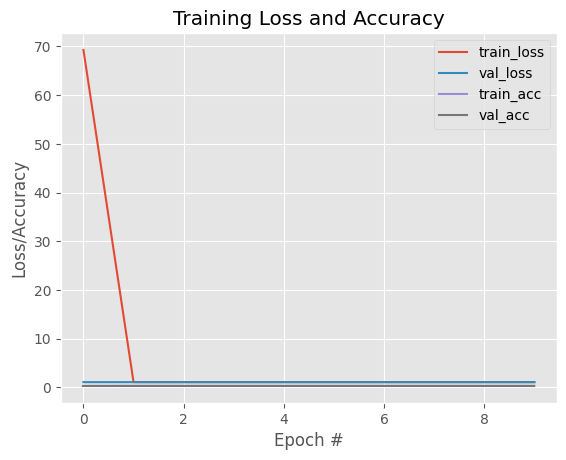

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Evaluamos el modelo con test
print("Evaluación del modelo...")
predictions = modelEffi.predict(images_test, batch_size=batch_size)
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1)))

# Gráfica de accuracy y losses
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

A diferencia de VGG16 y ResNet50, este modelo es más notablemente más rápido, y es probable que optimizando los hiper parámetros, reentrenando algunas capas más y dándole tiempo de entrenamiento, logremos mejorar los resultados. Por ahora, probaremos alguna alternativa más.


### **3.4.1 Parte transformers. ViT**

Si bien hasta ahora estabamos trabajando con CNNs, también puede ser positivo explorar el potencial de los transformers.

Probemos con **ViT**.

Haremos una prueba para explorar algo de su potencial y resultados. Si bien aún no conocemos esta arquitectura, la diferencia general de los modelos transformer es que no dependen de conexiones recurrentes para capturar la dependencia temporal, sino que utilizan una estructura que se basa en la **atención**, para **aprender relaciones no locales** entre elementos de la secuencia en un solo paso.

In [ ]:
#!pip install transformers
#!pip install datasets

In [ ]:
# PRUEBA PARA EXTRAER EMBEDDING DE UNA IMÁGEN DEL DATASET

### Dejo esta prueba de manera ilustrativa para poder volver a ella en el futuro ###

from transformers import AutoImageProcessor, TFViTModel
#from datasets import load_dataset
import tensorflow as tf

#dataset = load_dataset("huggingface/cats-image")
#image = dataset["test"]["image"][0]

image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

inputs = image_processor(images_train[0],return_tensors="tf")
outputs = model(**inputs)

last_hidden_states =outputs.last_hidden_state

embedding = tf.reduce_mean(last_hidden_states, axis=1)

print(list(last_hidden_states.shape))
print(list(embedding))

In [ ]:
#!pip install transformers

In [ ]:
# Vamos a extraer los embeddings de nuestros datos, del modelo.

from transformers import AutoImageProcessor, TFViTModel
import tensorflow as tf
import numpy as np

image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
modelViTClasif = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

# Procesar y extraer embeddings
embeddings_train = []
for image in images_train:
  inputs = image_processor(image, return_tensors='tf')
  outputs = modelViTClasif(**inputs)
  last_hidden_states = outputs.last_hidden_state
  embedding = tf.reduce_mean(last_hidden_states, axis=1)
  embeddings_train.append(embedding.numpy())

# Reconvertir los embeddings al formato para entrenar
X_emb_img_train = np.vstack(embeddings_train)

# Procesar y extraer embeddings
embeddings_val = []
for image in images_val:
  inputs = image_processor(image, return_tensors='tf')
  outputs = modelViTClasif(**inputs)
  last_hidden_states = outputs.last_hidden_state
  embedding = tf.reduce_mean(last_hidden_states, axis=1)
  embeddings_val.append(embedding.numpy())

# Reconvertir los embeddings al formato para entrenar
X_emb_img_val = np.vstack(embeddings_val)

# Procesar y extraer embeddings
embeddings_test = []
for image in images_test:
  inputs = image_processor(image, return_tensors='tf')
  outputs = modelViTClasif(**inputs)
  last_hidden_states = outputs.last_hidden_state
  embedding = tf.reduce_mean(last_hidden_states, axis=1)
  embeddings_test.append(embedding.numpy())

# Reconvertir los embeddings al formato para entrenar
X_emb_img_test = np.vstack(embeddings_test)


All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [ ]:
# Creamos el clasificador personalizado para pasarle los embeddings obtenidos del modelo ViT:

from keras.layers import Dense, Dropout
from tensorflow.keras import Model

inputs = tf.keras.Input(shape=(X_emb_img_train.shape[1],))
x = Dense(128, activation='relu')(inputs)
predictions = Dense(3, activation='softmax')(x)

modelViT = Model(inputs, predictions)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

epochs = 500
batch_size = 32

# Compilamos y entrenamos

# Vamos a probar a reducir el LR de forma dinámica para tratar de mejorar los resultados
def learning_rate_scheduler(epoch, learning_rate):
  if epoch % epochs_drop == 0 and epoch != 0:
    return learning_rate * drop_rate
  else:
    return learning_rate

initial_learning_rate = 1e-3
epochs_drop = 25
drop_rate = 0.9
lr_scheduler = LearningRateScheduler(learning_rate_scheduler)
optimizer = Adam(learning_rate=initial_learning_rate)

# Vamos a utilizar también early stopping para no perder demasiado tiempo si no hay mejora
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

modelViT.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
H = modelViT.fit(X_emb_img_train, y_train, validation_data=(X_emb_img_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[lr_scheduler, early_stopping])

Epoch 1/500
64/64 [==============================] - 1s 8ms/step - loss: 1.0649 - accuracy: 0.4294 - val_loss: 1.0907 - val_accuracy: 0.3833 - lr: 0.0010
Epoch 2/500
64/64 [==============================] - 0s 5ms/step - loss: 1.0653 - accuracy: 0.4186 - val_loss: 1.0774 - val_accuracy: 0.3944 - lr: 0.0010
Epoch 3/500
64/64 [==============================] - 0s 7ms/step - loss: 1.0629 - accuracy: 0.4284 - val_loss: 1.0805 - val_accuracy: 0.4194 - lr: 0.0010
Epoch 4/500
64/64 [==============================] - 0s 5ms/step - loss: 1.0611 - accuracy: 0.4348 - val_loss: 1.0795 - val_accuracy: 0.4139 - lr: 0.0010
Epoch 5/500
64/64 [==============================] - 0s 7ms/step - loss: 1.0640 - accuracy: 0.4230 - val_loss: 1.0772 - val_accuracy: 0.3972 - lr: 0.0010
Epoch 6/500
64/64 [==============================] - 0s 5ms/step - loss: 1.0653 - accuracy: 0.4250 - val_loss: 1.0800 - val_accuracy: 0.4111 - lr: 0.0010
Epoch 7/500
64/64 [==============================] - 0s 5ms/step - loss: 1.0

In [ ]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
# Evaluamos el modelo con test
print("Evaluación del modelo...")
predictions = modelViT.predict(X_emb_img_test, batch_size=64)
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1)))

Evaluación del modelo...
10/10 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.45      0.67      0.54       188
           1       0.44      0.65      0.52       188
           2       0.28      0.05      0.09       224

    accuracy                           0.43       600
   macro avg       0.39      0.46      0.38       600
weighted avg       0.38      0.43      0.37       600



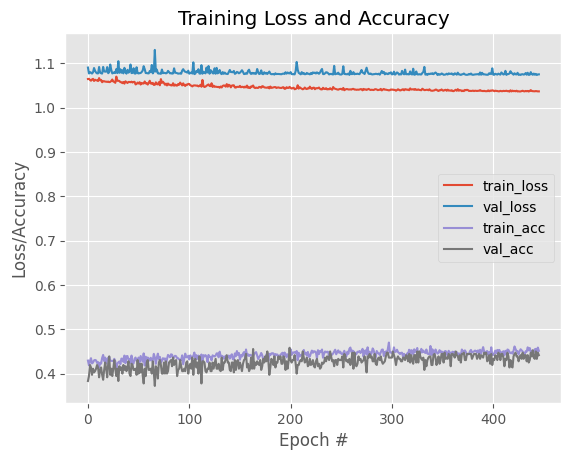

In [ ]:
import matplotlib.pyplot as plt

# Gráfica de accuracy y losses
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, len(H.history["loss"])), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, len(H.history["val_loss"])), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, len(H.history["accuracy"])), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, len(H.history["val_accuracy"])), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

Construyendo un clasificador en base a los embedded obtenidos de ViT, estamos logrando unos resultados mejores, ya que podemos hacer un entrenamiento más rápido, con más épocas y probando diferentes parámetros.

### **3.4.2 Parte Trainer. ViT (Parte experimental, no es funcional todavía**)

Esta parte es solo de prueba, no se han llegado a obtener resultados. No obstante se incluye con el fin de ampliar posibilidades y poder continuar con ello tras la práctica.

El objetivo aquí es tratar de reentrenar algunas capas del modelo antes de obtener los embedded, utilizando **Trainer** o alguna función similar.

In [ ]:
#!pip install Trainer

In [ ]:
# Parece ser que Trainer solo está implementado para PyTorch y que con TensorFlow solo se puede entrenar de la forma habitual las capas del clasificador
### DEJAMOS ESTA PARTE AQUÍ INDICADA PARA TRATAR DE PROFUNDIZAR MÁS EN ELLO Y VER LA POSIBILIDAD DE REENTRENAR PARTES DE LA RED ViT ANTES DE PASAR AL CLASIFICADOR ###

from transformers.training_args_tf import TrainingArguments
from transformers import Trainer
from tensorflow.keras.optimizers import Adam

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    num_train_epochs = 3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    #learning_rate = 1e-3,
    weight_decay=1e-2
)

trainer = Trainer(
    model = modelViTClasif, # modelViT
    args = training_args,
    train_dataset = X_emb_img_train,
    eval_dataset = X_emb_img_val,
    optimizer = Adam(learning_rate = 1e-3)
)

trainer_t = trainer.train()

A continuación, se intenta reentrenar antes de extraer embeddings. No está todavía funcional, se seguirá viendo tras la práctica.

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model
from keras.layers import Dense
from tensorflow.keras.models import Sequential
from transformers import AutoImageProcessor, TFViTModel, ViTConfig, ViTModel
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt


image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
modelViTClasif = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

for layer in modelViTClasif.layers:
  layer.trainable = False # Congelamos

classifier = Sequential([
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')
])

# Combinamos ViT y el clasificador
inputs = tf.keras.Input(shape=(224, 224, 3))
inputs_transposed = tf.transpose(inputs, perm=[0, 3, 1, 2]) # El modelo ViT requiere las dimensiones en un orden diferente
pretrained_output = modelViTClasif(inputs_transposed)
output = classifier(pretrained_output.last_hidden_state)
model_union = Model(inputs, output)



All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [ ]:
# Ahora extraemos los embeddings

# Procesar y extraer embeddings
embeddings_train = []
for image in images_train:
  inputs = image_processor(image, return_tensors='tf')
  outputs = modelViTClasif(**inputs)
  last_hidden_states = outputs.last_hidden_state
  embedding = tf.reduce_mean(last_hidden_states, axis=1)
  embeddings_train.append(embedding.numpy())

# Reconvertir los embeddings al formato para entrenar
X_emb_img_train = np.vstack(embeddings_train)

# Procesar y extraer embeddings
embeddings_val = []
for image in images_val:
  inputs = image_processor(image, return_tensors='tf')
  outputs = modelViTClasif(**inputs)
  last_hidden_states = outputs.last_hidden_state
  embedding = tf.reduce_mean(last_hidden_states, axis=1)
  embeddings_val.append(embedding.numpy())

# Reconvertir los embeddings al formato para entrenar
X_emb_img_val = np.vstack(embeddings_val)

# Procesar y extraer embeddings
embeddings_test = []
for image in images_test:
  inputs = image_processor(image, return_tensors='tf')
  outputs = modelViTClasif(**inputs)
  last_hidden_states = outputs.last_hidden_state
  embedding = tf.reduce_mean(last_hidden_states, axis=1)
  embeddings_test.append(embedding.numpy())

# Reconvertir los embeddings al formato para entrenar
X_emb_img_test = np.vstack(embeddings_test)

In [ ]:
# Entrenamos el modelo "combinado"
model_union.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['Accuracy'])

#X_emb_img_train_reshape = X_emb_img_train.reshape(-1, 224, 224, 3)
#X_emb_img_val_reshape = X_emb_img_val.reshape(-1, 224, 224, 3)
#X_emb_img_test_reshape = X_emb_img_test.reshape(-1, 224, 224, 3)

H = model_union.fit(X_emb_img_train_reshape, y_train, validation_data=(X_emb_img_val_reshape, y_val), epochs=500, batch_size=64)

## **4. Fusión de modelos**

Ahora vamos a trabajar en la fusión de los modelos.
Para ello, tomaremos de la parte tabular el **modelo ML XGBoost**, que es el que nos dió mejor resultado, y de la parte de imágenes tomaremos el **clasificador** que hicimos sobre la arquitectura de transformers ViT

Por limpieza y para tener todo junto, primero reescribiremos los modelos que utilizaremos para la fusión:

In [ ]:
# Modelo XGBoost

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Recordemos que GridSearch nos dió los mejores parámetros:
# best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}

xgb = XGBClassifier(random_state = 0, max_depth = 5, learning_rate = 1e-2, n_estimators = 200)
xgb.fit(X_train, y_train)

y_pred_xgb_val = xgb.predict(X_val)

accuracy_xgb_val = accuracy_score(y_val, y_pred_xgb_val)

print("Precisión de XGBoost en el conjunto de validación: ", accuracy_xgb_val)




Precisión de XGBoost en el conjunto de validación:  0.6833333333333333


In [ ]:
# Evaluación en conjunto de test
y_pred_xgb_test = xgb.predict(X_test)

print("Precisión de XGBoost en el conjunto de test: ", accuracy_score(y_test, y_pred_xgb_test))

Precisión de XGBoost en el conjunto de test:  0.6916666666666667


In [ ]:
#!pip install transformers

In [ ]:
# Modelo ViT

from transformers import AutoImageProcessor, TFViTModel
import tensorflow as tf
import numpy as np
from keras.layers import Dense
from tensorflow.keras import Model
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
modelViTClasif = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

# Procesar y extraer embeddings
embeddings_train = []
for image in images_train:
  inputs = image_processor(image, return_tensors='tf')
  outputs = modelViTClasif(**inputs)
  last_hidden_states = outputs.last_hidden_state
  embedding = tf.reduce_mean(last_hidden_states, axis=1)
  embeddings_train.append(embedding.numpy())

# Reconvertir los embeddings al formato para entrenar
X_emb_img_train = np.vstack(embeddings_train)

# Procesar y extraer embeddings
embeddings_val = []
for image in images_val:
  inputs = image_processor(image, return_tensors='tf')
  outputs = modelViTClasif(**inputs)
  last_hidden_states = outputs.last_hidden_state
  embedding = tf.reduce_mean(last_hidden_states, axis=1)
  embeddings_val.append(embedding.numpy())

# Reconvertir los embeddings al formato para entrenar
X_emb_img_val = np.vstack(embeddings_val)

# Procesar y extraer embeddings
embeddings_test = []
for image in images_test:
  inputs = image_processor(image, return_tensors='tf')
  outputs = modelViTClasif(**inputs)
  last_hidden_states = outputs.last_hidden_state
  embedding = tf.reduce_mean(last_hidden_states, axis=1)
  embeddings_test.append(embedding.numpy())

# Reconvertir los embeddings al formato para entrenar
X_emb_img_test = np.vstack(embeddings_test)



All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [ ]:
# Creamos el clasificador personalizado:

inputs = tf.keras.Input(shape=(X_emb_img_train.shape[1],))
x = Dense(128, activation='relu')(inputs)
predictions = Dense(3, activation='softmax')(x)

modelViT = Model(inputs, predictions)

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam

epochs = 100
batch_size = 32

# Compilamos y entrenamos

# Vamos a probar a reducir el LR de forma dinámica para tratar de mejorar los resultados
def learning_rate_scheduler(epoch, learning_rate):
  if epoch % epochs_drop == 0 and epoch != 0:
    return learning_rate * drop_rate
  else:
    return learning_rate

initial_learning_rate = 1e-3
epochs_drop = 10
drop_rate = 0.9
lr_scheduler = LearningRateScheduler(learning_rate_scheduler)
optimizer = Adam(learning_rate=initial_learning_rate)

# Vamos a utilizar también early stopping para no perder demasiado tiempo si no hay mejora
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

modelViT.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
H = modelViT.fit(X_emb_img_train, y_train, validation_data=(X_emb_img_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[lr_scheduler, early_stopping])

Epoch 1/100
64/64 [==============================] - 4s 27ms/step - loss: 1.0285 - accuracy: 0.4701 - val_loss: 1.0841 - val_accuracy: 0.4306 - lr: 0.0010
Epoch 2/100
64/64 [==============================] - 1s 12ms/step - loss: 1.0311 - accuracy: 0.4534 - val_loss: 1.0702 - val_accuracy: 0.4389 - lr: 0.0010
Epoch 3/100
64/64 [==============================] - 1s 11ms/step - loss: 1.0228 - accuracy: 0.4544 - val_loss: 1.0930 - val_accuracy: 0.3972 - lr: 0.0010
Epoch 4/100
64/64 [==============================] - 1s 18ms/step - loss: 1.0345 - accuracy: 0.4485 - val_loss: 1.0727 - val_accuracy: 0.4250 - lr: 0.0010
Epoch 5/100
64/64 [==============================] - 1s 14ms/step - loss: 1.0312 - accuracy: 0.4549 - val_loss: 1.0956 - val_accuracy: 0.4278 - lr: 0.0010
Epoch 6/100
64/64 [==============================] - 1s 9ms/step - loss: 1.0301 - accuracy: 0.4461 - val_loss: 1.0692 - val_accuracy: 0.4444 - lr: 0.0010
Epoch 7/100
64/64 [==============================] - 1s 9ms/step - loss

In [ ]:
# Evaluamos el modelo en el conjunto de validación
print("Evaluación del modelo...")
y_pred_modelViT_val = modelViT.predict(X_emb_img_val, batch_size=64)
print(classification_report(y_val.argmax(axis=1), y_pred_modelViT_val.argmax(axis=1)))

y_pred_modelViT_test = modelViT.predict(X_emb_img_test, batch_size=64)
print(classification_report(y_test.argmax(axis=1), y_pred_modelViT_test.argmax(axis=1)))

Evaluación del modelo...
6/6 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.45      0.45      0.45       127
           1       0.42      0.75      0.54       121
           2       0.38      0.05      0.09       112

    accuracy                           0.43       360
   macro avg       0.41      0.42      0.36       360
weighted avg       0.42      0.43      0.37       360

10/10 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.48      0.63      0.54       188
           1       0.43      0.72      0.53       188
           2       0.46      0.07      0.12       224

    accuracy                           0.45       600
   macro avg       0.45      0.47      0.40       600
weighted avg       0.45      0.45      0.38       600



Vamos ya con la **fusión**.

Vamos a comenzar trabajando con una **fusión de las predicciones**.
Probaremos con dos enfoques diferentes:
- **Voto mayoritario**: Aquí, cada modelo emitirá su predicción y se selecciona la clase con mayor frecuencia entre las predicciones de los modelos individuales.
- **Promedio**: En este caso, en lugar de considerar las predicciones individuales, se promedian las probabilidades de clase de los modelos individuales para obtener una probabilidad promedio ponderada.


In [ ]:
# Voto mayoritario

import numpy as np

# Combinamos las predicciones
y_pred_combined_major = np.argmax(y_pred_xgb_val, axis=1) + np.argmax(y_pred_modelViT_val, axis=1)

# Calculamos la precisión del modelo combinado en el conjunto de validación
accuracy_combined_maj_vote = accuracy_score(np.argmax(y_val, axis=1), y_pred_combined_major)

print("Accuracy del modelo fusionado en el conjunto de validación: ", accuracy_combined_maj_vote)


Accuracy del modelo fusionado en el conjunto de validación:  0.31666666666666665


In [ ]:
# Evaluamos el modelo con test
print("Evaluación del modelo...")
#y_combined_test = np.argmax(y_test, axis=1)

y_pred_combined_major_test = np.argmax(y_pred_xgb_test, axis=1) + np.argmax(y_pred_modelViT_test, axis=1)

print("Evaluación del modelo fusionado en el conjunto de test (Voto mayoritario): ")
print(classification_report(y_test.argmax(axis=1), y_pred_combined_major_test))

Evaluación del modelo...
Evaluación del modelo fusionado en el conjunto de test (Voto mayoritario): 
              precision    recall  f1-score   support

           0       0.71      0.59      0.64       188
           1       0.26      0.19      0.22       188
           2       0.36      0.29      0.33       224
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0

    accuracy                           0.35       600
   macro avg       0.27      0.21      0.24       600
weighted avg       0.44      0.35      0.39       600



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Voto promedio

# Calculamos el promedio
y_pred_avg = (y_pred_xgb_val + y_pred_modelViT_val) / 2

# Obtenemos las clases predichas con argmax
y_pred_combined_avg = np.argmax(y_pred_avg, axis = 1)

# Calculamos la precisión del modelo combinado en el conjunto de validación
accuracy_combined_avg = accuracy_score(np.argmax(y_val, axis=1), y_pred_combined_avg)

print("Accuracy del modelo fusionado en el conjunto de validación: ", accuracy_combined_avg)

Accuracy del modelo fusionado en el conjunto de validación:  0.725


In [ ]:
# Evaluamos el modelo con test
print("Evaluación del modelo...")
#y_combined_test = np.argmax(y_test, axis=1)

y_pred_avg_test = (y_pred_xgb_test + y_pred_modelViT_test) / 2

# Obtenemos las clases predichas con argmax
y_pred_combined_avg_test = np.argmax(y_pred_avg_test, axis = 1)

print("Evaluación del modelo fusionado en el conjunto de test (Promedio): ")
print(classification_report(y_test.argmax(axis=1), y_pred_combined_avg_test))

Evaluación del modelo...
Evaluación del modelo fusionado en el conjunto de test (Promedio): 
              precision    recall  f1-score   support

           0       0.72      0.92      0.81       188
           1       0.74      0.68      0.71       188
           2       0.71      0.58      0.64       224

    accuracy                           0.72       600
   macro avg       0.72      0.73      0.72       600
weighted avg       0.72      0.72      0.71       600



Estamos viendo como usando Voto promedio los resultados son considerablemente superiores a Voto mayoritario. No obstante, avanzaremos algo más que eso.

Ahora vamos a trabajar con **Early y Late Fussion:**

Vamos a comenzar trabajando con **Early Fussion**. Esta metodología consiste en una fusión a nivel de características, lo que implica que el input del nuevo modelo serán los vectores (embedded) que obtenemos en el modelo ViT antes de aplicar el clasificador, para las imágenes, y las mismas features que le pasamos al XGBoost con los datos tabulares.



### **Early Fussion**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Defino el modelo de red neuronal para fusionar
# Inputs de cada modelo
input_vit = Input(shape=(X_emb_img_train.shape[1],)) # Pasamos el vector embedded del modelo ViT
input_xgb = Input(shape=(X_train.shape[1],)) # Pasamos X_train en el input

# Capas para el modelo
dense_vit = Dense(64, activation='relu')(input_vit)
#reduced_vit = Dense(3, activation='relu')(dense_vit)
dense_xgb = Dense(64, activation='relu')(input_xgb)

# Concatenamos ambas capas
concatenated_output = Concatenate()([dense_vit, dense_xgb])

# Agregamos capas para la fusión
dense_combined = Dense(64, activation='relu')(concatenated_output)
output = Dense(3, activation='softmax')(dense_combined)

# Definimos el modelo
model_combined_early = Model([input_vit, input_xgb], output)

# Compilamos y entrenamos

def learning_rate_scheduler(epoch, learning_rate): # En pruebas estoy viendo que hay saltos en el loss, así que vamos a aplicar una reducción de LR
  if epoch % epochs_drop == 0 and epoch != 0:
    return learning_rate * drop_rate
  else:
    return learning_rate

initial_learning_rate = 1e-4
epochs_drop = 50
drop_rate = 0.9
lr_scheduler = LearningRateScheduler(learning_rate_scheduler)

# Vamos a utilizar también early stopping para no perder demasiado tiempo si no hay mejora
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

optimizer = Adam(learning_rate=initial_learning_rate)
model_combined_early.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model_combined_early.fit([X_emb_img_train, X_train], y_train, validation_data=([X_emb_img_val, X_val], y_val), epochs=500, batch_size=32, callbacks=[lr_scheduler, early_stopping])

Epoch 1/500
64/64 [==============================] - 2s 7ms/step - loss: 13.2220 - accuracy: 0.3387 - val_loss: 5.9666 - val_accuracy: 0.3528 - lr: 1.0000e-04
Epoch 2/500
64/64 [==============================] - 0s 4ms/step - loss: 5.5767 - accuracy: 0.3814 - val_loss: 7.2440 - val_accuracy: 0.3694 - lr: 1.0000e-04
Epoch 3/500
64/64 [==============================] - 0s 5ms/step - loss: 4.4371 - accuracy: 0.4098 - val_loss: 2.9546 - val_accuracy: 0.4056 - lr: 1.0000e-04
Epoch 4/500
64/64 [==============================] - 0s 4ms/step - loss: 2.0750 - accuracy: 0.4348 - val_loss: 2.4258 - val_accuracy: 0.4222 - lr: 1.0000e-04
Epoch 5/500
64/64 [==============================] - 0s 5ms/step - loss: 1.7562 - accuracy: 0.4446 - val_loss: 2.6100 - val_accuracy: 0.4139 - lr: 1.0000e-04
Epoch 6/500
64/64 [==============================] - 0s 4ms/step - loss: 3.5122 - accuracy: 0.4265 - val_loss: 11.2627 - val_accuracy: 0.3944 - lr: 1.0000e-04
Epoch 7/500
64/64 [==============================]

In [ ]:
# Evaluamos el modelo con test
print("Evaluación del modelo...")

y_pred_model_combined_early_test = model_combined_early.predict([X_emb_img_test, X_test])
print(classification_report(y_test.argmax(axis=1), y_pred_model_combined_early_test.argmax(axis=1)))

Evaluación del modelo...
19/19 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       188
           1       0.73      0.78      0.75       188
           2       0.73      0.62      0.67       224

    accuracy                           0.74       600
   macro avg       0.74      0.75      0.75       600
weighted avg       0.74      0.74      0.74       600



In [ ]:
# Ahora probemos un modelo ML con XGBoost
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

combined_features_train = np.concatenate([X_emb_img_train, X_train], axis=1)
combined_features_val = np.concatenate([X_emb_img_val, X_val], axis=1)
combined_features_test = np.concatenate([X_emb_img_test, X_test], axis=1)

# Entrenamos el clasificador XGBoost
xgb_model_combined = XGBClassifier()
xgb_model_combined.fit(combined_features_train, y_train)

# Predicciones en el conjunto de validación
y_pred_combined_val = xgb_model_combined.predict(combined_features_val)

print("Evaluación del modelo...")

print("Informe resultado modelo fusión XGBoost en conjunto de validación:")
print(classification_report(y_val.argmax(axis=1), y_pred_combined_val.argmax(axis=1)))

# Predicciones en el conjunto de test
y_pred_combined_test = xgb_model_combined.predict(combined_features_test)

print("Informe resultado modelo fusión XGBoost en conjunto de test:")
print(classification_report(y_test.argmax(axis=1), y_pred_combined_test.argmax(axis=1)))

Evaluación del modelo...
Informe resultado modelo fusión XGBoost en conjunto de validación:
              precision    recall  f1-score   support

           0       0.62      0.87      0.72       127
           1       0.84      0.64      0.72       121
           2       0.62      0.49      0.55       112

    accuracy                           0.68       360
   macro avg       0.69      0.67      0.67       360
weighted avg       0.69      0.68      0.67       360

Informe resultado modelo fusión XGBoost en conjunto de test:
              precision    recall  f1-score   support

           0       0.60      0.94      0.74       188
           1       0.76      0.67      0.71       188
           2       0.73      0.46      0.56       224

    accuracy                           0.68       600
   macro avg       0.70      0.69      0.67       600
weighted avg       0.70      0.68      0.66       600



Por ahora en **Early Fussion** nos están dando mejores resultados con el modelo de **Red Neuronal** (0.74) con capas densas frente al modelo de **Boosted Trees** (0.68)

Ahora probaremos con la **Late Fussion**

Vamos a obtener las predicciones de cada uno de los modelos y las pasaremos a un nuevo clasificador

### **Late Fussion**

In [ ]:
# Combinamos las predicciones
from tensorflow.keras.layers import concatenate

combined_features_train = concatenate([xgb.predict(X_train), modelViT.predict(X_emb_img_train)]) # Le llamo combined_features a las variables, aunque sería más correcto combined_predictions
combined_features_val = concatenate([xgb.predict(X_val), modelViT.predict(X_emb_img_val)])
combined_features_test = concatenate([xgb.predict(X_test), modelViT.predict(X_emb_img_test)])

19/19 [==============================] - 0s 2ms/step


In [ ]:
# Vamos a entrenar un modelo sencillo de red neuronal con capas densas
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler


model_combined_early = Sequential()
#model_combined_early.add(Dense(64, activation='relu')) # Hemos probado a agregar algunas capas extra
#model_combined_early.add(Dropout(0.25))
model_combined_early.add(Dense(64, activation='relu'))
model_combined_early.add(Dropout(0.25))
model_combined_early.add(Dense(3, activation='softmax'))


# Compilamos y entrenamos

# Vamos a controlar el Learning rate para tratar de mejorar el resultado
def learning_rate_scheduler(epoch, learning_rate):
  if epoch % epochs_drop == 0 and epoch != 0:
    return learning_rate * drop_rate
  else:
    return learning_rate

initial_learning_rate = 5e-3
epochs_drop = 10
drop_rate = 0.9

lr_scheduler = LearningRateScheduler(learning_rate_scheduler)

# Vamos a utilizar también early stopping para no perder demasiado tiempo
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

optimizer = Adam(learning_rate=initial_learning_rate)

model_combined_early.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model_combined_early.fit(combined_features_train, y_train, validation_data=(combined_features_val, y_val), epochs=100, batch_size=32, callbacks=[lr_scheduler, early_stopping])





Epoch 1/100
64/64 [==============================] - 3s 14ms/step - loss: 0.6780 - accuracy: 0.7647 - val_loss: 0.7163 - val_accuracy: 0.7250 - lr: 0.0050
Epoch 2/100
64/64 [==============================] - 0s 6ms/step - loss: 0.5688 - accuracy: 0.8029 - val_loss: 0.7109 - val_accuracy: 0.7250 - lr: 0.0050
Epoch 3/100
64/64 [==============================] - 0s 7ms/step - loss: 0.5497 - accuracy: 0.8025 - val_loss: 0.7136 - val_accuracy: 0.7250 - lr: 0.0050
Epoch 4/100
64/64 [==============================] - 0s 7ms/step - loss: 0.5571 - accuracy: 0.8069 - val_loss: 0.7248 - val_accuracy: 0.7250 - lr: 0.0050
Epoch 5/100
64/64 [==============================] - 0s 7ms/step - loss: 0.5564 - accuracy: 0.8025 - val_loss: 0.7052 - val_accuracy: 0.7250 - lr: 0.0050
Epoch 6/100
64/64 [==============================] - 0s 7ms/step - loss: 0.5613 - accuracy: 0.8034 - val_loss: 0.7139 - val_accuracy: 0.7250 - lr: 0.0050
Epoch 7/100
64/64 [==============================] - 0s 6ms/step - loss: 0.

In [ ]:
# Evaluamos el modelo con test
print("Evaluación del modelo...")

y_pred_model_combined_early_test = model_combined_early.predict(combined_features_test, batch_size=32)
print(classification_report(y_test.argmax(axis=1), y_pred_model_combined_early_test.argmax(axis=1)))

Evaluación del modelo...
19/19 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.77      0.91      0.84       188
           1       0.81      0.66      0.73       188
           2       0.71      0.71      0.71       224

    accuracy                           0.76       600
   macro avg       0.76      0.76      0.76       600
weighted avg       0.76      0.76      0.75       600



El mejor resultado que estamos obteniendo es **0.76** en test

Con ambos tipos de fusión, hemos obtenido unos resultados que no son muy diferentes, siendo algo superiores en Late Fussion (**0.74 en Early frente a 0.76 en Late**).
Creo que aún podrían mejorarse algo los resultados en Late fussion optimizando hiper parámetros y agregando alguna capa más, pero por razones de tiempo no haremos más modificaciones dentro de la práctica. En todo caso, al recibir los resultados de los otros modelos y pasarlos a un clasificador sencillo, el modelo aprende y obtiene el resultado final en muy pocas épocas.

Nos quedariamos en definitiva para este caso concreto, con los resultados de Late Fussion.

## **5. Conclusiones**

En primer lugar, indicar que durante la elaboración de esta práctica he descubierto y aprendido un gran número de posibilidades y formas de trabajar con redes neuronales. Del mismo modo, queda claro que apenas estamos arañando la superficie de posibilidades y el potencial de este mundo de las redes neuronales.

Respecto del trabajo en sí, hay varios factores en los que me gustaría poder profundizar.
El **primero** de estos sería, las posibilidades de mejora de resultados de esta práctica con los conocimientos actuales y sobre lo ya hecho.
En este sentido, me gustaría haber podido profundizar más en todos y cada uno de los modelos en los que he trabajado, esto es, tener el tiempo de buscar los mejores hiper-parámetros, y tratar de probar con un buen número de modificaciones a las arquitecturas y reentrenamientos de diversas capas. Estoy seguro de que así podría haber mejorado los resultados.
También en este aspecto hablar de un análisis más profundo de los datos para obtener un mejor set de datos de entrenamientos con los que trabajar (o uno más refinado, más allá del análisis somero que he realizado).

El **segundo** factor, sería las posibilidades de mejora de esta práctica respecto de la infraestructura. En este aspecto, decidí trabajar con las imágenes en tamaño normal, y realicé la práctica con un dataset de 3.000 imágenes. Mi intención era posteriormente, tratar de optimizar los resultados utilizando el dataset completo de casi 15.000, pero tras varios intentos de descarga, cada uno de ellos de algo más de 3 horas, Colab me expulsaba de la sesión. El mismo problema tuve para entrenar por ejemplo en VGG y en ResNet, por lo que en esta ocasión debí conformarme con trabajar con esta limitación (supongo que versiones de pago en Colab o algunas otras alternativas pueden solucionar estos inconvenientes. No quiero decir con esto que Colab no sea una gran ayuda para este tipo de trabajos).

El tercer factor, y con el que me quedo personalmente motivado para el futuro, tanto para este trabajo como para todos los que vengan, es lo todavía desconocido. Me gustaría poder ampliar y comprender con mucha mayor profundidad el funcionamiento de las redes neuronales, ya que entre otras cosas, hay factores limitantes en no conocer lo profundo de las redes, respecto a la elección de arquitecturas, hiper-parámetros y otros. Por ejemplo, creo que podría hacer un trabajo infinitamente mejor fuera capaz de comprender cómo construir arquitecturas para diferentes tipos de problemas, además de conocer qué hiper-parámetros se pueden ajustar mejor a determinados problemas y estructuras.

Para finalizar, indicar que el mundo del ML Deep Learning es apasionante y espero seguir profundizando en él y alcanzar una comprensión más amplia e integral de este.